### Geometric Brownian Motion for stock price estimation in future

[*********************100%%**********************]  1 of 1 completed


<Axes: title={'center': 'Price of TSLA from 2019-05-07 00:00:00 to 2024-05-06 00:00:00'}, xlabel='Date'>

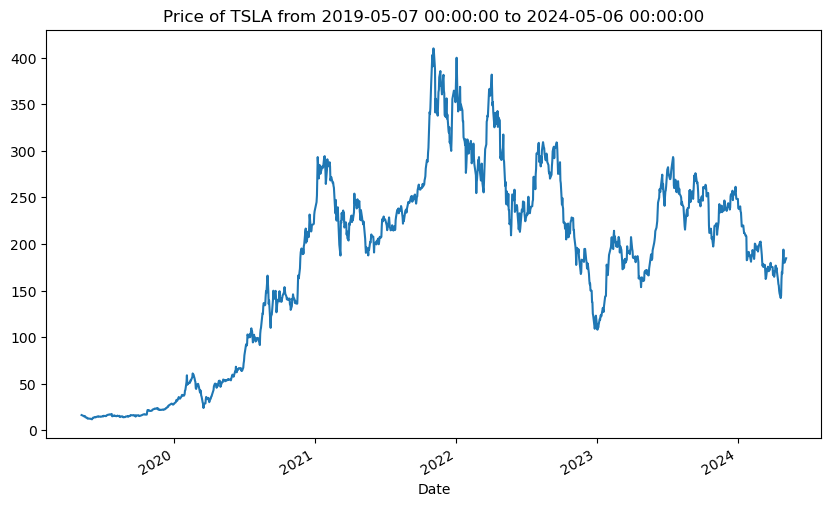

In [2]:
# getting historical data for Tesla. This code calls the API and transforms the result into a DataFrame.
import numpy as np
np.random.seed(3363)
import pandas as pd

from scipy.stats import norm
import datetime 

import matplotlib.pyplot as plt
%matplotlib inline
ticker = "TSLA" #Tesla Stock

import yfinance as yf
df=yf.download(ticker, period='5y')

#Plot of asset historical closing price
df['Adj Close'].plot(figsize=(10, 6), title = "Price of {} from {} to {}".format(ticker, df.index.min(), df.index.max()))

### Geometric Brownian Motion

assuming the log of the returns (percent changes) are normally distributed and that the market is efficient

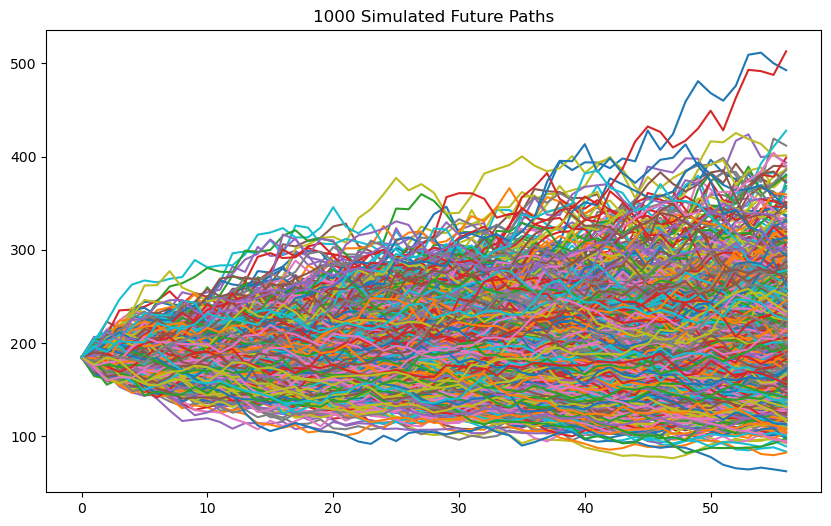

In [3]:
pred_end_date = datetime.datetime(2024, 7, 1)

def monte_carlo(pred_end_date, df=df, iterations=1000, plot=True):
    pred_end_date = pred_end_date
    forecast_dates = [d if d.isoweekday() in range(1, 6) else np.nan for d in pd.date_range(df.index.max(), pred_end_date)] 
    intervals = len(forecast_dates)
    iterations = iterations
    #Preparing log returns from data
    log_returns = np.log(1 + df['Adj Close'].pct_change())

    #Setting up drift and random component in relation to asset data
    u = log_returns.mean()
    var = log_returns.var()
    drift = u - (0.5 * var)
    stdev = log_returns.std()
    daily_returns = np.exp(drift + stdev * norm.ppf(np.random.rand(intervals, iterations)))

    #Takes last data point as startpoint point for simulation

    price_list = np.zeros_like(daily_returns)
    price_list[0] = df['Adj Close'].values[-1]
    #Applies Monte Carlo simulation in asset
    for t in range(1, intervals):
        price_list[t] = price_list[t - 1] * daily_returns[t]

    forecast_df = pd.DataFrame(price_list)
    
    if plot: 
        forecast_df.plot(figsize=(10,6), legend=False, title = "{} Simulated Future Paths".format(iterations))
    
    end_values_df = forecast_df.tail(1)
    
    return forecast_df, end_values_df

forecast_df, end_values_df = monte_carlo(pred_end_date)

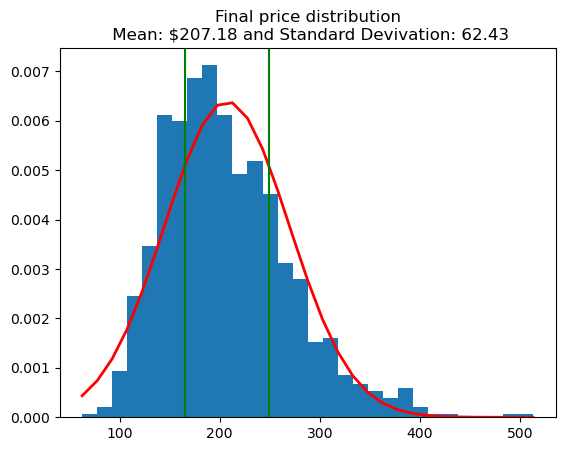

In [4]:
def plot_norm_hist(s, vline = True, title= True):
    mu, sigma = np.mean(s), np.std(s) # mean and standard deviation

    count, bins, ignored = plt.hist(s, 30, density=True)
    plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
    
    if vline:
        lline = -.67*sigma + mu
        uline = .67*sigma + mu
        plt.axvline(lline, color='g')
        plt.axvline(uline, color='g')

    if title:
        plt.title("Final price distribution\n Mean: ${:.02f} and Standard Devivation: {:.02f}".format(mu, sigma))
    
    return plt.show()
        
s = end_values_df.iloc[-1]
plot_norm_hist(s, vline=True, title=True)